# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
#I am trying to mimic very deep convolutional network (as per https://arxiv.org/pdf/1409.1556.pdf)
#In order to not use-pretrained VGG model, I am trying to mimic with batch normalization below

In [3]:
# Define transforms
## YOUR CODE HERE ##
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, 4),
    transforms.ToTensor(),
    normalize
    ])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

# Create training set and define training dataloader
## YOUR CODE HERE ##
trainset = torchvision.datasets.CIFAR10('~/.pytorch/CIFAR_data/', download=True, train=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Create test set and define test dataloader
## YOUR CODE HERE ##
testset = torchvision.datasets.CIFAR10('~/.pytorch/CIFAR_data/', download=True, train=False, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

In [5]:
# Explore data
## YOUR CODE HERE ##
show5(trainloader)

car


ValueError: Floating point image RGB values must be in the 0..1 range.

truck


ValueError: Floating point image RGB values must be in the 0..1 range.

ship


ValueError: Floating point image RGB values must be in the 0..1 range.

truck


ValueError: Floating point image RGB values must be in the 0..1 range.

cat


ValueError: Floating point image RGB values must be in the 0..1 range.

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [6]:
## YOUR CODE HERE ##

import math

cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
}

class Classifier(nn.Module):
    def __init__(self, features):
        super().__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 10),
        )
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [7]:
## YOUR CODE HERE ##

criterion = nn.CrossEntropyLoss()


model = Classifier(make_layers(cfg['A'], batch_norm=True))
model.features = torch.nn.DataParallel(model.features)
print(model)

optimizer = torch.optim.SGD(model.parameters(), lr=0.05,
                                momentum=0.9,
                                weight_decay=5e-4)




Classifier(
  (features): DataParallel(
    (module): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace)
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace)
      (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [8]:
## YOUR CODE HERE ##

number_of_epochs = 45
train_loss_history = list()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

for epoch in range(number_of_epochs):
    train_loss = 0.0
    train_correct = 0
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        
        if torch.cuda.is_available():
            
            inputs, labels = data[0].to(device), data[1].to(device)
            model.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()

    print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(trainloader):.2f}% training loss: {train_loss/len(trainloader):.5f}')
    train_loss_history.append(train_loss/len(trainloader))

Epoch 1 training accuracy: 23.04% training loss: 1.68742
Epoch 2 training accuracy: 34.74% training loss: 1.28147
Epoch 3 training accuracy: 40.37% training loss: 1.07300
Epoch 4 training accuracy: 43.36% training loss: 0.95823
Epoch 5 training accuracy: 44.83% training loss: 0.90063
Epoch 6 training accuracy: 46.48% training loss: 0.83443
Epoch 7 training accuracy: 47.21% training loss: 0.80456
Epoch 8 training accuracy: 48.03% training loss: 0.77153
Epoch 9 training accuracy: 48.61% training loss: 0.74423
Epoch 10 training accuracy: 49.03% training loss: 0.72283
Epoch 11 training accuracy: 49.25% training loss: 0.70742
Epoch 12 training accuracy: 50.02% training loss: 0.67999
Epoch 13 training accuracy: 49.96% training loss: 0.67850
Epoch 14 training accuracy: 50.31% training loss: 0.66656
Epoch 15 training accuracy: 50.63% training loss: 0.65244
Epoch 16 training accuracy: 50.61% training loss: 0.65105
Epoch 17 training accuracy: 50.94% training loss: 0.64335
Epoch 18 training accur

Plot the training loss (and validation loss/accuracy, if recorded).

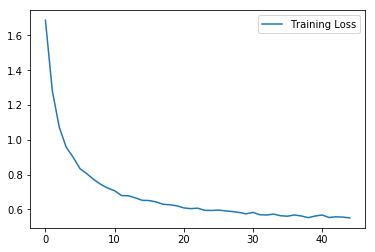

In [9]:
## YOUR CODE HERE ##
plt.plot(train_loss_history, label="Training Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [10]:
## YOUR CODE HERE ##
total = 0

val_loss_history = list()
val_loss = 0.0
val_correct = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for inputs, labels in testloader:
        
        if torch.cuda.is_available():
            inputs, labels = data[0].to(device), data[1].to(device)
            model.to(device)
            
        # calculate outputs by running images through the network
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()
        
        total += labels.size(0)
    
    ## No Epoch here or batches, removed the irrelevant code which caused ambiguity. 
    
    
    val_loss_history.append(val_loss/len(testloader))

print(f'Accuracy of the network on test images: {100 * val_correct // total} %')

Accuracy of the network on test images: 93 %


In [11]:
## Measure predictions for each class

In [12]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        if torch.cuda.is_available():
            images, labels = data[0].to(device), data[1].to(device)
            model.to(device)
            
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 84.2 %
Accuracy for class: car   is 90.0 %
Accuracy for class: bird  is 64.1 %
Accuracy for class: cat   is 58.3 %
Accuracy for class: deer  is 78.6 %
Accuracy for class: dog   is 75.8 %
Accuracy for class: frog  is 86.9 %
Accuracy for class: horse is 85.4 %
Accuracy for class: ship  is 84.3 %
Accuracy for class: truck is 90.0 %


## Saving your model
Using `torch.save`, save your model for future loading.

In [13]:
## YOUR CODE HERE ##
PATH = './.CIFAR_10_trained_model.pth'
torch.save(model.state_dict(), PATH)

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?

    - Build a solution in-house effectively and provide inference for image classification. 

* How does it compare to the far more advanced solutions in the literature?

    - I have tried to mimic very deep convolutional network VGG with batch normalization with instead of using pre-trained and transfer learn. The above said model architecture looks like following

```
Classifier(
  (features): DataParallel(
    (module): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace)
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace)
      (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (13): ReLU(inplace)
      (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (16): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (17): ReLU(inplace)
      (18): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (19): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (20): ReLU(inplace)
      (21): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (22): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (23): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (24): ReLU(inplace)
      (25): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (26): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (27): ReLU(inplace)
      (28): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU(inplace)
    (6): Linear(in_features=512, out_features=10, bias=True)
  )
)
```
* What did you do to get the accuracy you achieved? 

    - Based on other convolutional neural network classes I have taken, convolutional layers or convnet involves several ways to manipulate dimensions and channels, augment pixels. As per my understanding, it is good to tap into pre-trained models with high accuracy and adapt a solution which suits to our problem. Hence, I have followed the same to get high accuracy. 

* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?

    - I guess, its a decent accuracy at per class level but defenitely model can be trained further and also different architectures can be tried to improve accuracy at class level. 



**Double click this cell to modify it**



## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).